
<font color='green' size=6 align='center'><p style='text-align: center;'>**Final Notebook**\
<font color=cian size=5 align='center'>**Sharon Nicolle Rodríguez Parada, saronparada@gmail.com**\
<font color=cian size=5 align='center'>         **Universidad Industrial de Santander**

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import scipy.io #scipy.io me permite leer datos construidos en matlab
from scipy import stats # importando scipy.stats
from scipy.signal import savgol_filter
import scipy as sio
import sklearn.metrics as skm
%matplotlib inline

## <font color=purple size=5> 1. Curva de calibracion

In [2]:
df = pd.read_excel('./Datos/Datos-azul-timol (1).xlsx',header = 1)

In [3]:
df

,Muestra,Absorbancia,Muestra.1,Absorbancia.1,Muestra.2,Absorbancia.2,[Molar],Longitud de onda,Absorbancia.3
0,Blanco,0.002,Blanco,0.002,Blanco,0.002,0.000000,400.0,0.126
1,Patrón 1,0.100,Patrón 1,0.090,Patrón 1,0.089,0.000003,400.5,0.125
2,Blanco,0.000,Blanco,0.000,Blanco,-0.001,0.000000,401.0,0.122
3,Patrón 2,0.276,Patrón 2,0.267,Patrón 2,0.267,0.000010,401.5,0.121
4,Blanco,-0.001,Blanco,-0.001,Blanco,-0.002,0.000000,402.0,0.119
...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.0,-0.004
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.5,-0.004
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,799.0,-0.004
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,799.5,-0.004


In [4]:
df.columns

Index(['Muestra', 'Absorbancia', 'Muestra.1', 'Absorbancia.1', 'Muestra.2',
       'Absorbancia.2', '[Molar]', 'Longitud de onda', 'Absorbancia.3'],
      dtype='object')

In [5]:
idx_extraer = df[(df.Muestra.str.contains('Blanco')) & (df.index > 0)].index
df.drop(idx_extraer,inplace=True)
df = df.reset_index(drop=True)[0:10]
dfCurvaF= df.copy()
dfCurvaF['Promedio'] = dfCurvaF[['Absorbancia', 'Absorbancia.1', 'Absorbancia.2']].mean(axis=1)
dfCurvaFin = dfCurvaF.drop(['Absorbancia', 'Absorbancia.1', 'Absorbancia.2'], axis=1)
dfCurvaFin.reset_index(drop=True, inplace=True)
cols1 = ['Muestra','[Molar]','Promedio']
dfCurvaFin=dfCurvaFin[cols1]

In [6]:
dfCurvaFin.head()

,Muestra,[Molar],Promedio
0,Blanco,0.000000,0.002000
1,Patrón 1,0.000003,0.093000
2,Patrón 2,0.000010,0.270000
3,Patrón 3,0.000017,0.483000
4,Patrón 4,0.000024,0.664333


In [10]:
x = dfCurvaFin[['[Molar]']] 
y = dfCurvaFin[['Promedio']]
reg = linear_model.LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
m=reg.coef_[0]
b=reg.intercept_[0]
mse=skm.mean_squared_error(y, y_pred)
r2=skm.r2_score(y, y_pred)

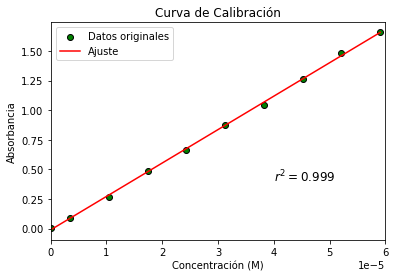

In [11]:
fig, ax= plt.subplots()
ax.scatter(x, y, color='green', label='Datos originales', edgecolors='black')
ax.plot(np.array(x), np.array(y_pred), color='red', label='Ajuste')
ax.legend()
ax.set_title("Curva de Calibración")
ax.set_xlabel("Concentración (M)")
ax.set_ylabel("Absorbancia")
ax.set_xlim(9e-19, 0.00006)
ax.text(0.00004,0.4, r"$r^2 = "+str("{0:.3f}".format(r2))+r"$", fontsize=12, color="black")
plt.show()

In [12]:
dfCurvaFin['Desviación'] = dfCurvaF[['Absorbancia', 'Absorbancia.1', 'Absorbancia.2']].std(axis=1)
YError = dfCurvaFin['Desviación']
dfCurvaFin.reset_index(drop=True, inplace=True)
dfCurvaFin.head()

,Muestra,[Molar],Promedio,Desviación
0,Blanco,0.000000,0.002000,0.000000
1,Patrón 1,0.000003,0.093000,0.006083
2,Patrón 2,0.000010,0.270000,0.005196
3,Patrón 3,0.000017,0.483000,0.001000
4,Patrón 4,0.000024,0.664333,0.008386


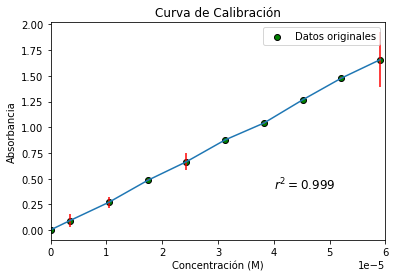

In [13]:
fig, ax= plt.subplots()
ax.scatter(x, y, color='green', label='Datos originales', edgecolors='black')
ax.set_xlim(9e-19, 0.00006)
ax.errorbar(np.squeeze(x.values),np.squeeze(y.values), yerr=10*YError.values, ecolor='red')
ax.legend()
ax.set_title("Curva de Calibración")
ax.set_xlabel("Concentración (M)")
ax.set_ylabel("Absorbancia")
ax.text(0.00004,0.4, r"$r^2 = "+str("{0:.3f}".format(r2))+r"$", fontsize=12, color="black")
plt.show()

## <font color=purple size=5> 2. Modelo

In [15]:
ASCI_IR=pd.read_excel("./Datos/ASCI_IR.xlsx", header=None)

prop=pd.read_excel("./Datos/Informacion Crudos20.xlsx", header=None)
prop.set_axis(['', '', '', '', 'ASCI', 'IN(ASCI)', '', '', '', '', '', ''], axis=1, inplace=True)
prop.drop([''],axis=1, inplace=True)
prop.drop([0],axis=0,inplace=True)
prop = prop.reset_index(drop=True)
prop.drop(0,inplace=True)
prop.drop(prop.index[-1],inplace=True)
prop1 = prop[["ASCI"]]
prop2 = prop[["IN(ASCI)"]]
ASCI_IR =  ASCI_IR.T

data_signals= np.array(ASCI_IR)
data_prop1 = np.array(prop1)
data_prop2 = np.array(prop2)

In [16]:
data_signals.shape, data_prop1.shape, data_prop2.shape


((82, 7469), (82, 1), (82, 1))

In [17]:
#normalizamos los datos
scaler=StandardScaler()
norma=Normalizer()

scaler.fit(data_signals) # calculo la media para poder hacer la transformacion
x_scaled=scaler.transform(data_signals)# Ahora si, escalo los datos y los normalizo
x_norm = preprocessing.normalize(data_signals, norm='l1')# Normaliza los datos
x_nsd = savgol_filter(x_norm, 17, polyorder=2, deriv=2) # Realiza segunda derivada de los datos

<font color='black' size=4 align='center'><p style='text-align: left;'>**Primera propiedad**

MSE = 0.41


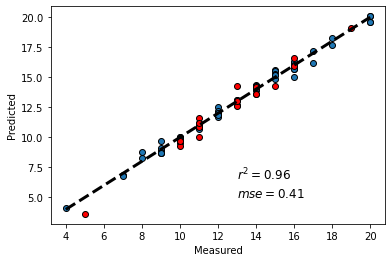

In [18]:
# Separación de los datos en set de entrenamiento y set de prueba
x_train, x_test, y_train, y_test = train_test_split(x_norm, data_prop1, train_size=0.8, random_state=22, shuffle= True)

pls = PLSRegression(n_components=10)
pls.fit(x_train, y_train)

y_pred = pls.predict(x_train)
y_pred_test = pls.predict(x_test)
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_test, y_pred_test, color='red', edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
ax.text(13,5, r"$mse = "+str(round(mean_squared_error(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.text(13,6.5, r"$r^2 = "+str(round(r2_score(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

print('MSE = ' + str(round(mean_squared_error(y_test, y_pred_test), 2)));

In [19]:
def optimise_pls(X, y, xt, n_comp):
    
    # Definimos PLS y el número de componentes
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_pred1 = pls.predict(X)
    y_pred2 = pls.predict(xt)
    # Calculamos métricas
    r2 = r2_score(y, y_pred1)
    mse = mean_squared_error(y, y_pred1)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_pred1, y_pred2, r2, mse, rpd)

In [20]:
r2s = []
mses = []
rpds = []
yp1 = []
yp2 = []
arr_rs = np.arange(1, 101)
for n_rs in arr_rs:
    x_train, x_test, y_train, y_test = train_test_split(x_norm, data_prop1, train_size=0.8, random_state=n_rs, shuffle= True)
    
    y_pred1, y_pred2, r2, mse, rpd = optimise_pls(x_train, y_train, x_test, 10)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    yp1.append(y_pred1)
    yp2.append(y_pred2)

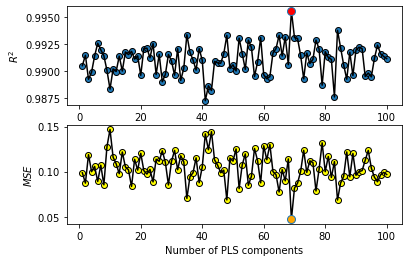

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1)
#fig, ax = plt.subplots()
ax1.scatter(arr_rs, r2s, edgecolors=(0, 0, 0))
ax1.plot(arr_rs, r2s, 'k-')
ax1.plot(arr_rs[np.argmax(r2s)], np.array(r2s)[np.argmax(r2s)], 'o', ms=8, mfc='red')
ax1.set_xlabel('Number of PLS components')
ax1.set_ylabel('$R^2$')

ax2.scatter(arr_rs, mses, color='yellow', edgecolors=(0, 0, 0))
ax2.plot(arr_rs, mses, 'k-')
ax2.plot(arr_rs[np.argmin(mses)], np.array(mses)[np.argmin(mses)], 'o', ms=8, mfc='orange')
ax2.set_xlabel('Number of PLS components')
ax2.set_ylabel('$MSE$')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
kf = KFold(n_splits=5, shuffle=True, random_state=20) # Vamos hacer 10 separaciones sin barajar en cada separación
model=PLSRegression(n_components=10) # Utilizamos 60 componentes de ajuste del modelo con PLS
x_traint = [] # Creamos arreglos de cada grupo de datos en los que almacenamos las diferentes divisiones 
x_testt = [] # Luego podremos utilizar la mejor separación para obtener el modelo más apropiado
y_traint = []
y_testt = []
r2s = []
mses = []

i = 1
for train_index, test_index in kf.split(x_norm):
    x_train = x_norm[train_index]
    x_test = x_norm[test_index]
    y_train = data_prop1[train_index]
    y_test = data_prop1[test_index]
    model.fit(x_train, y_train) #Training the model
    mse = mean_squared_error(y_test, model.predict(x_test))
    r2= r2_score(y_test, model.predict(x_test))
    
    # Almacenamos cada grupo en los arreglos creados
    x_traint.append(x_train) 
    x_testt.append(x_test)
    y_traint.append(y_train)
    y_testt.append(y_test)
    r2s.append(r2)
    mses.append(mse)
   
    # Entrenamos el modelo para cada separación the model
    model.fit(x_train, y_train) #Training the model
    print(f"MSE. {i} on the test set: {mean_squared_error(y_test, model.predict(x_test))}")
    print(f"R2. {i} on the test set: {r2_score(y_test, model.predict(x_test))}")
    i += 1

MSE. 1 on the test set: 0.13249433415967785
R2. 1 on the test set: 0.9892501789522328
MSE. 2 on the test set: 0.37561725817960046
R2. 2 on the test set: 0.9667829291267122
MSE. 3 on the test set: 0.5305727554279158
R2. 3 on the test set: 0.9683240146013185
MSE. 4 on the test set: 0.4600372011035245
R2. 4 on the test set: 0.9352914706140097
MSE. 5 on the test set: 0.4596608484220405
R2. 5 on the test set: 0.9565941803039313


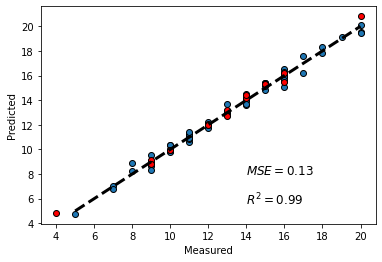

In [23]:
y_tr=np.array(y_traint[r2s.index(max(r2s))]) # Escogemos el mejor set a partir del que presente el
y_te=np.array(y_testt[r2s.index(max(r2s))]) # el valor máximo de r2. Podríamos también elegir el que
X_tr=np.array(x_traint[r2s.index(max(r2s))]) # presente el menor valor del mse
X_te=np.array(x_testt[r2s.index(max(r2s))])
model.fit(X_tr, y_tr) # Ejecutamos el modelo PLS con el set de entranamiento de mejor comportamiento

Y_pred = model.predict(X_tr) # Con el modelo predicmos los valos de la propiedad
Y_pred_test = model.predict(X_te) # Evaluamos las muestras de prueba

fig, ax = plt.subplots()
ax.scatter(y_tr, Y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_te, Y_pred_test, color='red', label='test set', edgecolors=(0, 0, 0))
ax.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--', lw=3)
ax.text(14,8, r"$MSE = "+str("{0:.2f}".format(mean_squared_error(y_te, Y_pred_test)))+r"$", fontsize=12, color="black")
ax.text(14,5.5, r"$R^2 = "+str("{0:.2f}".format(r2_score(y_tr, Y_pred)))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

<font color='black' size=4 align='center'><p style='text-align: left;'>**Segunda propiedad**

MSE = 10.33


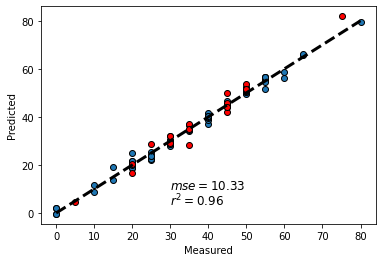

In [24]:
# Separación de los datos en set de entrenamiento y set de prueba
x_train, x_test, y_train, y_test = train_test_split(x_norm, data_prop2, train_size=0.8, random_state=22, shuffle= True)

pls = PLSRegression(n_components=10)
pls.fit(x_train, y_train)

y_pred = pls.predict(x_train)
y_pred_test = pls.predict(x_test)
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_test, y_pred_test, color='red', edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
ax.text(30,10, r"$mse = "+str(round(mean_squared_error(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.text(30,3, r"$r^2 = "+str(round(r2_score(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

print('MSE = ' + str(round(mean_squared_error(y_test, y_pred_test), 2)));

In [25]:
r2s = []
mses = []
rpds = []
yp1 = []
yp2 = []
arr_rs = np.arange(1, 101)
for n_rs in arr_rs:
    x_train, x_test, y_train, y_test = train_test_split(x_norm, data_prop2, train_size=0.8, random_state=n_rs, shuffle= True)
    
    y_pred1, y_pred2, r2, mse, rpd = optimise_pls(x_train, y_train, x_test, 10)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    yp1.append(y_pred1)
    yp2.append(y_pred2)

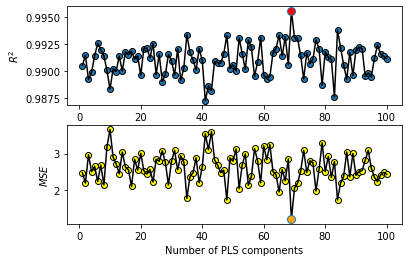

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1)
#fig, ax = plt.subplots()
ax1.scatter(arr_rs, r2s, edgecolors=(0, 0, 0))
ax1.plot(arr_rs, r2s, 'k-')
ax1.plot(arr_rs[np.argmax(r2s)], np.array(r2s)[np.argmax(r2s)], 'o', ms=8, mfc='red')
ax1.set_xlabel('Number of PLS components')
ax1.set_ylabel('$R^2$')

ax2.scatter(arr_rs, mses, color='yellow', edgecolors=(0, 0, 0))
ax2.plot(arr_rs, mses, 'k-')
ax2.plot(arr_rs[np.argmin(mses)], np.array(mses)[np.argmin(mses)], 'o', ms=8, mfc='orange')
ax2.set_xlabel('Number of PLS components')
ax2.set_ylabel('$MSE$')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
kf = KFold(n_splits=5, shuffle=True, random_state=1) # Vamos hacer 10 separaciones sin barajar en cada separación
model=PLSRegression(n_components=10) # Utilizamos 60 componentes de ajuste del modelo con PLS
x_traint = [] # Creamos arreglos de cada grupo de datos en los que almacenamos las diferentes divisiones 
x_testt = [] # Luego podremos utilizar la mejor separación para obtener el modelo más apropiado
y_traint = []
y_testt = []
r2s = []
mses = []

i = 1
for train_index, test_index in kf.split(x_norm):
    x_train = x_norm[train_index]
    x_test = x_norm[test_index]
    y_train = data_prop2[train_index]
    y_test = data_prop2[test_index]
    model.fit(x_train, y_train) #Training the model
    mse = mean_squared_error(y_test, model.predict(x_test))
    r2= r2_score(y_test, model.predict(x_test))
    
    # Almacenamos cada grupo en los arreglos creados
    x_traint.append(x_train) 
    x_testt.append(x_test)
    y_traint.append(y_train)
    y_testt.append(y_test)
    r2s.append(r2)
    mses.append(mse)
   
    # Entrenamos el modelo para cada separación the model
    model.fit(x_train, y_train) #Training the model
    print(f"MSE. {i} on the test set: {mean_squared_error(y_test, model.predict(x_test))}")
    print(f"R2. {i} on the test set: {r2_score(y_test, model.predict(x_test))}")
    i += 1

MSE. 1 on the test set: 12.054319848378464
R2. 1 on the test set: 0.9713157806819154
MSE. 2 on the test set: 4.611528033205344
R2. 2 on the test set: 0.9785389436135854
MSE. 3 on the test set: 9.572992231180118
R2. 3 on the test set: 0.9616481062412815
MSE. 4 on the test set: 13.568730301233563
R2. 4 on the test set: 0.9470488573610397
MSE. 5 on the test set: 7.822821348310977
R2. 5 on the test set: 0.9623563483991051


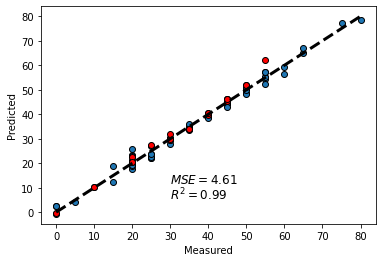

In [28]:
y_tr=np.array(y_traint[r2s.index(max(r2s))]) # Escogemos el mejor set a partir del que presente el
y_te=np.array(y_testt[r2s.index(max(r2s))]) # el valor máximo de r2. Podríamos también elegir el que
X_tr=np.array(x_traint[r2s.index(max(r2s))]) # presente el menor valor del mse
X_te=np.array(x_testt[r2s.index(max(r2s))])
model.fit(X_tr, y_tr) # Ejecutamos el modelo PLS con el set de entranamiento de mejor comportamiento

Y_pred = model.predict(X_tr) # Con el modelo predicmos los valos de la propiedad
Y_pred_test = model.predict(X_te) # Evaluamos las muestras de prueba

fig, ax = plt.subplots()
ax.scatter(y_tr, Y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_te, Y_pred_test, color='red', label='test set', edgecolors=(0, 0, 0))
ax.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--', lw=3)
ax.text(30,12, r"$MSE = "+str("{0:.2f}".format(mean_squared_error(y_te, Y_pred_test)))+r"$", fontsize=12, color="black")
ax.text(30,5, r"$R^2 = "+str("{0:.2f}".format(r2_score(y_tr, Y_pred)))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()